In [18]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm
from tqdm import trange

The Data I am using is the preproccessed data I created from Regression Trees

In [19]:
# this ensures that the current MacOS version is at least 12.3+
# print(torch.backends.mps.is_available())
# print(torch.backends.mps.is_built()
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device('cpu')
device

device(type='cpu')

In [20]:
path = '/Users/charlie/ML/Stocks/Data/processed_tqqq_trades.csv'

In [21]:
df = pd.read_csv(path)
df.head()

,Num Of Trading Min,LastBuyScore,Position Num of Buys,Position Current Price Real,Position Current Price 10 Min avg,Security Trade Signal,Security Trade Signal Reason,Security Trade Score,Opp Security,Opp Security Trade Score,...,Daily Max Gain Percent From Open,Daily Max Gain Loss Ratio From Open,Daily Current Gain Loss Diff From Open Close,Position Trailing Stop,Position Trailing Percent,Position Trailing Loss Percent,Position Last Sell DT,Position Num of Days Since Last Sell,Opp Pos Num of Days Since Last Buy,Opp Pos Num of Days Since Last Sell
0,307,-0.752129,1,66.780,66.8420,0,6,-5.967799,0,5.209109,...,0.710174,0.260137,0.500860,0,0,0,0,4.0,0,0
1,53,-0.827437,1,65.115,64.9925,0,6,-2.304925,0,-1.995048,...,0.608254,-0.796144,1.647675,0,0,0,1,1.0,1,1
2,93,-0.890121,2,65.555,65.4275,0,6,3.168636,0,-3.562561,...,1.053280,-1.623550,1.647675,0,0,0,2,0.0,1,1
3,23,1.049423,1,67.205,67.0900,0,6,4.192252,0,-4.907624,...,2.148334,2.234280,-0.926137,0,0,0,3,1.0,2,2
4,21,2.056933,1,69.405,69.4000,0,4,8.306845,0,-9.292201,...,2.334315,2.389321,-0.905744,0,0,0,4,1.0,3,3


In [24]:
df['LastBuyScore'].value_counts()

-0.752129    1
-0.808127    1
 2.756511    1
-0.825767    1
-1.293507    1
            ..
 0.306810    1
-0.929860    1
-0.849948    1
 1.996791    1
-1.007869    1
Name: LastBuyScore, Length: 348, dtype: int64

The Ratio of the classes is 48:52
This means that if we get a accuracy of above 52% it means the model worked

In [25]:
len(df)

348

The data is split in a way so that the model can not "fill in the holes" but predict the future

In [26]:
train = df.head(300)
test = df.tail(48)

In [27]:
datax = df.drop(columns=['LastBuyScore'])
datay = df['LastBuyScore']

trainx = train.drop(columns=['LastBuyScore'])
trainy = train['LastBuyScore']

testx = test.drop(columns=['LastBuyScore'])
testy = test['LastBuyScore']

In [28]:
def sliding_windows(X, Y, seq_length):
    x = []
    y = []

    for i in range(len(X)-seq_length-1):
        _x = X[i:(i+seq_length)]
        _y = Y[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

Creating the data with a length of 25 (Can change the length to improve accuracy)

In [29]:
seq_length = 28
xtrain, ytrain = sliding_windows(trainx.to_numpy(), trainy.to_numpy(), seq_length)
xtest, ytest = sliding_windows(testx.to_numpy(), testy.to_numpy(), seq_length)
xdata, ydata = sliding_windows(datax.to_numpy(), datay.to_numpy(), seq_length)

In [31]:
dataX = Variable(torch.Tensor(np.array(xdata))).to(device)
dataY = Variable(torch.Tensor(np.array(ydata))).to(device)

trainX = Variable(torch.Tensor(np.array(xtrain))).to(device)
trainY = Variable(torch.Tensor(np.array(ytrain))).to(device)

testX = Variable(torch.Tensor(np.array(xtest))).to(device)
testY = Variable(torch.Tensor(np.array(ytest))).to(device)

Creating the model

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out

In [33]:
def classify(input):
    for i in range(len(input)):
        if input[i] > 0.5:
            input[i] = 1
        else:
            input[i] = 0
    return input

In [34]:
def get_accuracy(a, b):
    correct = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            correct += 1
    return correct / len(a)


In [35]:
input_dim = 67
hidden_dim = 32
num_layers = 4
output_dim = 1
num_epochs = 5000

In [36]:
def eval(train_best_preds, trainy, valid_bestpreds, valid_preds, valid_y, train_loss_plot, valid_loss_plot):
    plt.plot(valid_bestpreds)
    plt.plot(valid_preds)
    plt.plot(valid_y)
    plt.legend(['bestpreds','Preds', 'Y'])
    plt.show()
    plt.plot(train_loss_plot)
    plt.plot(valid_loss_plot)
    plt.legend(['train_loss_plot', 'valid_loss_plot'])
    plt.show()
    plt.plot(train_best_preds.detach().numpy())
    plt.plot(trainy)
    plt.legend(['train_best_preds', 'trainY'])
    print(valid_loss_plot.min())


100%|██████████| 5000/5000 [04:31<00:00, 18.40it/s]


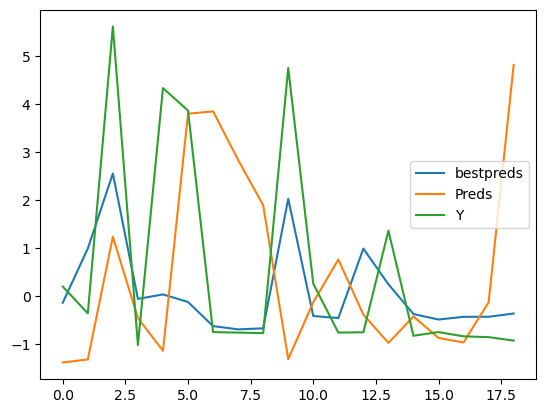

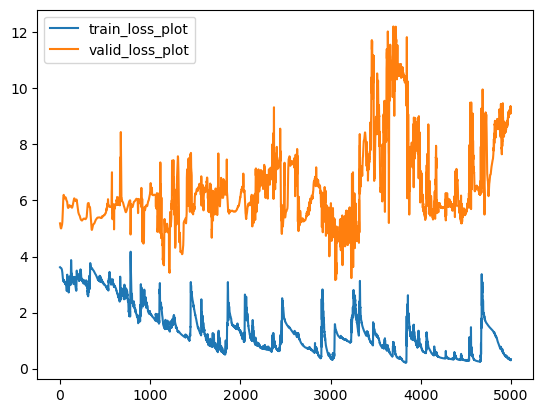

3.159759283065796


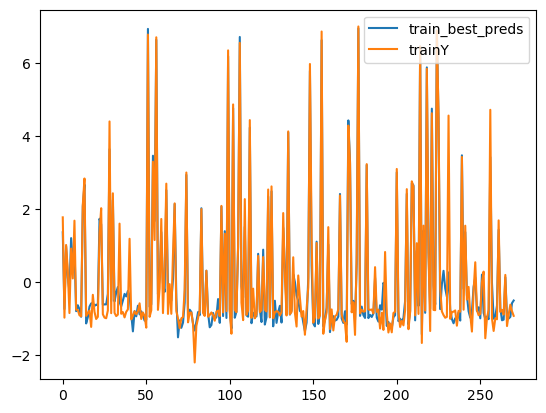

In [37]:
def run():
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    # criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    criterion = torch.nn.MSELoss(reduction='mean')
    # optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss_plot = np.array([])
    valid_loss_plot = np.array([])
    for epoch in trange(num_epochs):
        model.train()
        y = model(trainX).flatten()
        loss = criterion(y, trainY)
        train_loss_plot = np.append(train_loss_plot, loss.item())
        if loss.item() == train_loss_plot.min():
            train_best_preds = y
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        # eval(y, trainY)
        model = model.eval()
        with torch.no_grad():
            y = model(testX).flatten()
            loss = criterion(y, testY)
            valid_loss_plot = np.append(valid_loss_plot, loss.item())
            if (loss.item() == valid_loss_plot.min()):
                valid_best_preds = y

    eval(train_best_preds, trainY, valid_best_preds, y, testY, train_loss_plot, valid_loss_plot)
    return valid_loss_plot
loss_plot = run()
# print(loss_plot[0], loss_plot.min(), loss_plot.max())

optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

77%

In [ ]:
mean = 0
trials = 0
for i in trange(trials):
    accuracy_plot = run()
    mean += accuracy_plot.max()
    # print(i)
mean /= trials
mean = max(100 - mean, mean)

0it [00:00, ?it/s]


ZeroDivisionError: division by zero

In [ ]:
accuracy_plot = run()
plt.plot(accuracy_plot)
print(accuracy_plot.max(), 100 - accuracy_plot.min())

TypeError: 'method' object is not iterable

ADAM:75

SGD:75
Cross Entropy better than MSE

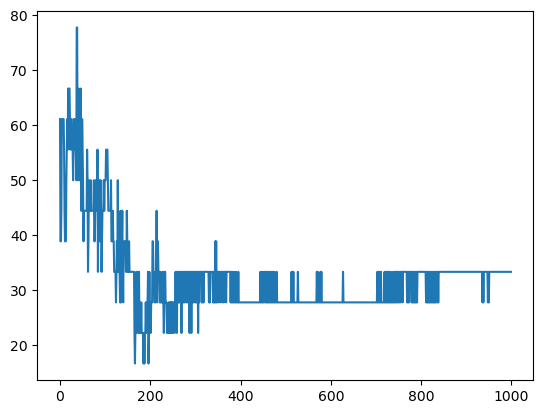

In [ ]:
plt.plot(accuracy_plot)
print(accuracy_plot.max())

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
accuracy_plot = np.array([])
for epoch in trange(num_epochs):
    model.train()
    y = model(trainX).flatten()
    loss = criterion(y, trainY)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    if epoch % 1 == 0:
        model = model.eval()
        with torch.no_grad():
            y = model(testX).flatten()
            preditced = classify(y.detach().numpy())
            accuracy_plot = np.append(accuracy_plot, 100 * get_accuracy(preditced, testY))

100%|██████████| 1000/1000 [00:17<00:00, 57.73it/s]


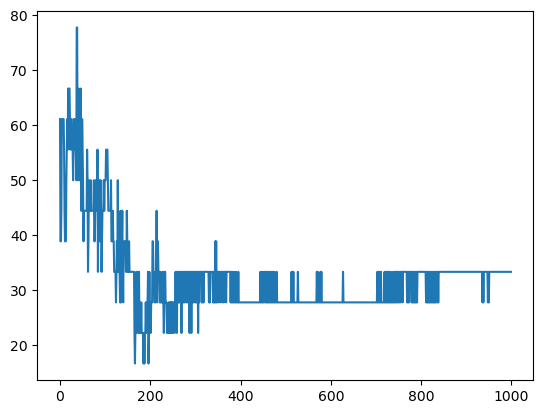

In [ ]:
plt.plot(accuracy_plot)

The graph above the the final accuracy of the model. In this graph, the accuracy is above 52%. However, the accuracy of the model fluxuates so I ran it multiple times to get the average and best accuracy. Keep in mind that the best accuracy could be overfitted. The mean be low because of a combnation of overfitting and too many epochs. The plots are the best metric in my opinion. (Because it is 11pm I am not going to package this into one function and run it that way)

In [ ]:
print(f"Mean:{int(accuracy_plot.mean())}% Max:{int(accuracy_plot.max())}%")

Mean:32% Max:77%


Mean:65% Max:88%

Mean:64% Max:83%

Mean:66% Max:83%

Mean:42% Max:72%

Mean:66% Max:83%

Mean:56% Max:72%

Mean:48% Max:77%

Mean:66% Max:77%

Mean:30% Max:66%

Mean:57% Max:72%

Ways to maybe improve the mode


SGD

Cross Entropy Loss

More Data

Tune Seq length

Tune Model archetecture

Feature engenerring

Maybe more but its 11:30pm im tired

In [ ]:
trainX

tensor([[[  1.,  94.,   1.,  ...,   5.,   2.,   2.],
         [  1.,  27.,   1.,  ...,   1.,   3.,   3.],
         [  1.,  40.,   1.,  ...,   5.,   8.,   8.],
         ...,
         [  1.,  95.,   1.,  ...,   1.,  11.,  11.],
         [  1.,  22.,   1.,  ...,   1.,  12.,  12.],
         [  1., 325.,   1.,  ...,   4.,  16.,  16.]],

        [[  1.,  27.,   1.,  ...,   1.,   3.,   3.],
         [  1.,  40.,   1.,  ...,   5.,   8.,   8.],
         [  0., 241.,   1.,  ...,  16.,   8.,   8.],
         ...,
         [  1.,  22.,   1.,  ...,   1.,  12.,  12.],
         [  1., 325.,   1.,  ...,   4.,  16.,  16.],
         [  0.,  36.,   1.,  ...,  20.,   4.,   4.]],

        [[  1.,  40.,   1.,  ...,   5.,   8.,   8.],
         [  0., 241.,   1.,  ...,  16.,   8.,   8.],
         [  1., 272.,   1.,  ...,  13.,   5.,   5.],
         ...,
         [  1., 325.,   1.,  ...,   4.,  16.,  16.],
         [  0.,  36.,   1.,  ...,  20.,   4.,   4.],
         [  1., 116.,   1.,  ...,   9.,   5.,   5.]],